# Make logoplots showing key sites of escape

In [1]:
import functools
import itertools
import operator
import os
import requests
import tarfile


import altair as alt

import dmslogo
import dmslogo.colorschemes

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd
import yaml

_ = alt.data_transformers.disable_max_rows()
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
min_entry = -3
min_ACE2 = -3
n_sites_to_show = 10

In [3]:
per_antibody_escape = pd.read_csv("../results/summaries/antibody_escape.csv")
# per_antibody_escape = pd.read_csv(snakemake.input.per_antibody_escape)

In [4]:
per_antibody_escape = per_antibody_escape.dropna()

filtered_df = per_antibody_escape[
    (per_antibody_escape['spike mediated entry'] >= min_entry) &
    (per_antibody_escape['ACE2 binding'] >= min_ACE2)
]

In [5]:
# for coloring by ACE2 binding
ace2_colormap = dmslogo.colorschemes.ValueToColorMap(
    minvalue=max(-4, filtered_df["ACE2 binding"].min()),
    maxvalue=0,
    cmap="Blues",
)

filtered_df["color"] = (
    filtered_df["ACE2 binding"]
    .clip(lower=ace2_colormap.minvalue, upper=ace2_colormap.maxvalue)
    .map(ace2_colormap.val_to_color)
)

for orientation in ["horizontal", "vertical"]:
    fig, _ = ace2_colormap.scale_bar(
        orientation=orientation, label="ACE2 binding",
    )
    # svg = os.path.join("results/escape_logos",f"key_escape_sites_ace2_scalebar_{orientation}.svg")
    # print(f"Saving to {svg}")
    # fig.savefig(svg, bbox_inches="tight")
    plt.close(fig)

/tmp/ipykernel_2894/3283088763.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["color"] = (


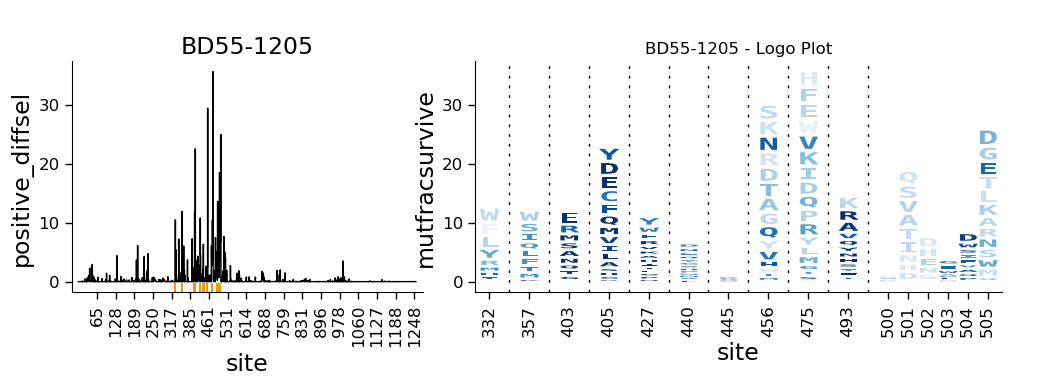

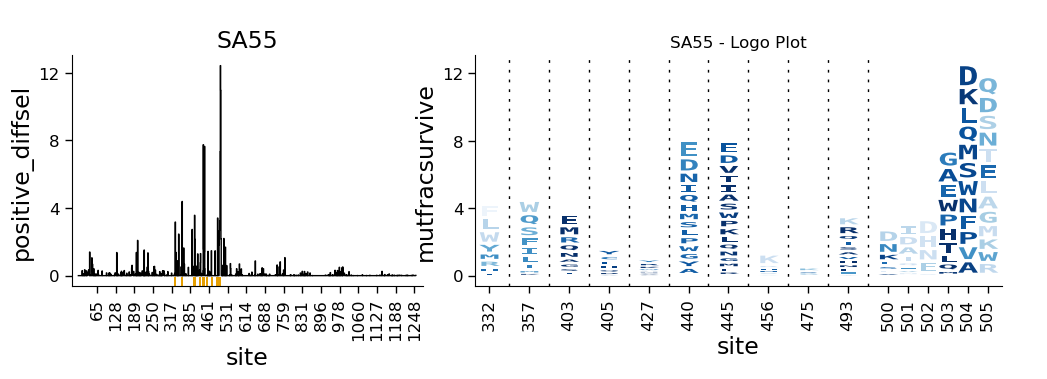

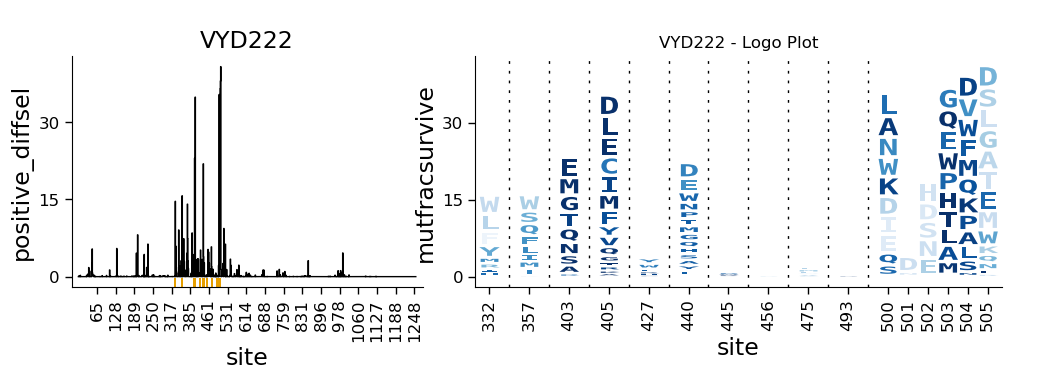

In [6]:
# Ensure 'site' is numeric 
filtered_df = filtered_df[filtered_df['site'].apply(lambda x: str(x).isdigit())].copy()
filtered_df['site'] = filtered_df['site'].astype(int)

# Melt to long format
antibody_cols = ['BD55-1205', 'SA55', 'VYD222']
long_df = filtered_df.melt(
    id_vars=['site', 'wildtype', 'mutant', 'color'],
    value_vars=antibody_cols,
    var_name='antibody',
    value_name='mutfracsurvive'
)

long_df = long_df.rename(columns={'mutant': 'mutation'})

# Compute site total escape
long_df['totfracsurvive'] = long_df.groupby(['antibody', 'site'])['mutfracsurvive'].transform('sum')

# Step 4: Add positive_diffsel
long_df['positive_diffsel'] = long_df['totfracsurvive'].clip(lower=0)

# Mark top 10 sites per antibody 
# Initialize show_site column
long_df['show_site'] = False

# Store all top 10 sites for each antibody
all_top_sites = set()

# First: mark top 10 per antibody and collect global top sites
for ab in antibody_cols:
    top_sites = (
        long_df[long_df['antibody'] == ab]
        .groupby('site')['totfracsurvive']
        .mean()
        .nlargest(10)
        .index
    )
    all_top_sites.update(top_sites)
    long_df.loc[(long_df['antibody'] == ab) & (long_df['site'].isin(top_sites)), 'show_site'] = True

# Second: also mark True if site is among the top 10 for any antibody
long_df.loc[long_df['site'].isin(all_top_sites), 'show_site'] = True


# Plot per antibody 
for ab in antibody_cols:
    df_ab = long_df.query('antibody == @ab').copy()

    # Map site to sequential integers for x_col
    unique_sites = sorted(df_ab['site'].unique())
    site_map = {s: i+1 for i, s in enumerate(unique_sites)}
    df_ab['isite'] = df_ab['site'].map(site_map)

    # Create figure
    fig, axes = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 1.5]})
    fig.subplots_adjust(wspace=0.12)
    fig.set_size_inches(12, 3)

    # Line plot (left) using positive_diffsel
    dmslogo.draw_line(
        df_ab,
        x_col="isite",
        height_col="positive_diffsel",
        xtick_col="site",
        show_col="show_site",
        ax=axes[0],
        title=f"{ab}"
    )

    # Logo plot (right) for top 10 sites
    dmslogo.draw_logo(
        df_ab.query("show_site"),
        x_col="isite",
        letter_col="mutation",
        letter_height_col="mutfracsurvive",
        clip_negative_heights=True,
        color_col="color",
        ax=axes[1],
        xtick_col="site",
    )
    axes[1].set_title(f"{ab} - Logo Plot")

    plt.show()

    # save svg
    # svg_path = os.path.join("results/escape_logos",f"{ab}_spike_DMS_line_logo_plot.svg")
    # fig.savefig(svg_path, format="svg", bbox_inches="tight")
    # print(f"Saved {svg_path}")

    plt.close(fig)

## Plot logoplots for Cao data

In [7]:
# URL for TAR file
tar_url = "https://zenodo.org/records/13893217/files/data_scripts_plots.tar.gz"
local_tar = "../results/escape_logos/data_scripts_plots.tar.gz"

# get the TAR file if it doesn't already exist
if not os.path.isfile(local_tar):
    print(f"Getting {tar_url=} to {local_tar=}")
    # Stream and save the file
    with requests.get(tar_url, stream=True) as response:
        response.raise_for_status()  # Ensure the request was successful
        with open(local_tar, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):  # Write in chunks
                file.write(chunk)
else:
    print(f"{local_tar=} already downloaded")

local_tar='../results/escape_logos/data_scripts_plots.tar.gz' already downloaded


In [8]:
target_file = "./data/DMS/antibody/dms_antibodies_XBB15_JN1_agg.csv"  # file w DMS data

# Open the TAR file and list its contents
with tarfile.open(local_tar, "r") as tar:
    file_names = tar.getnames()  # Get list of file names in the TAR archive
    # print(f"\nContents of {local_tar=}:\n\t" + "\n\t".join(file_names))
    assert target_file in file_names, f"{target_file=} not in {local_tar=}"
    print(f"Reading {target_file=} from {local_tar=}")
    f = tar.extractfile(target_file)
    df = pd.read_csv(f)

df['antibody'] = df['antibody'].replace('BD55-5514', 'SA55')

Reading target_file='./data/DMS/antibody/dms_antibodies_XBB15_JN1_agg.csv' from local_tar='../results/escape_logos/data_scripts_plots.tar.gz'


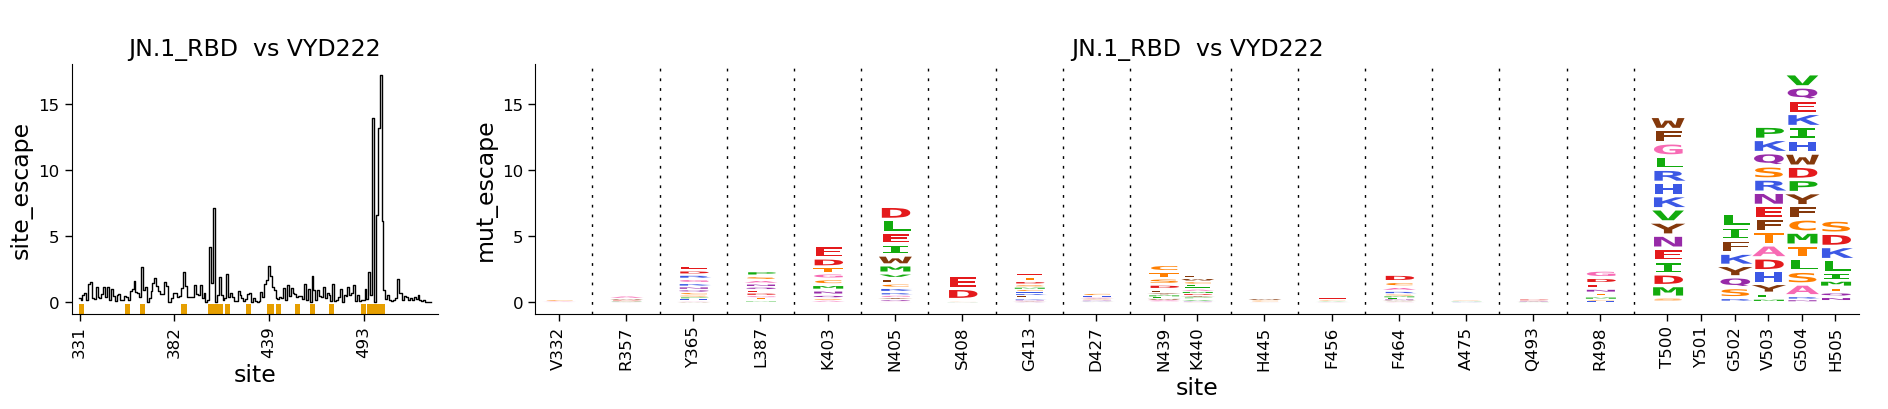

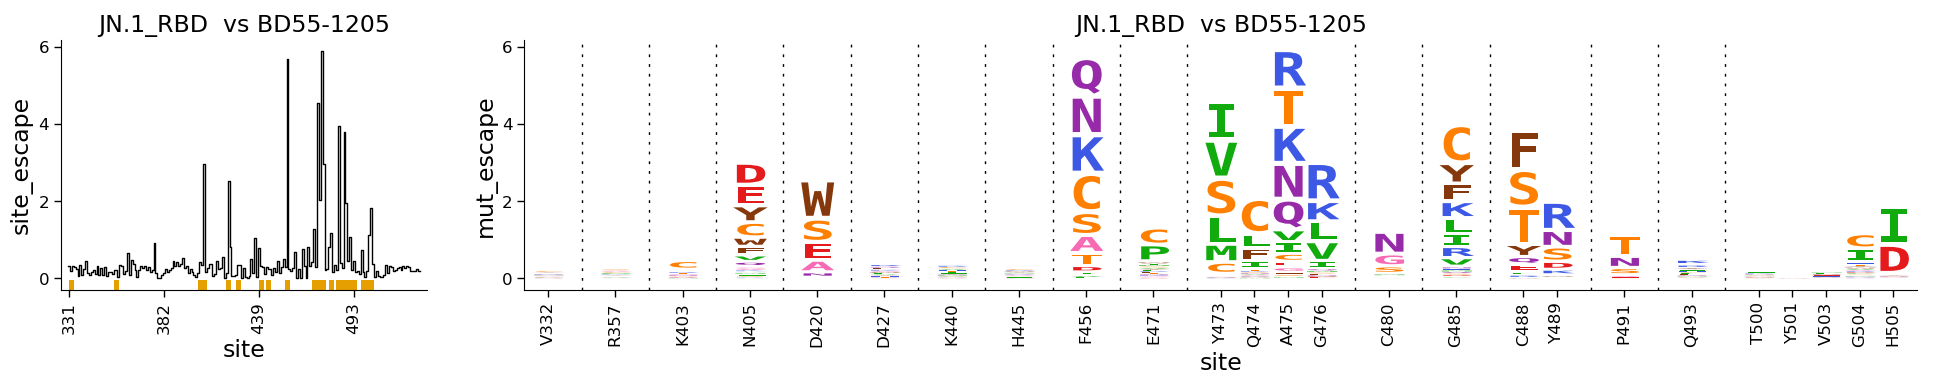

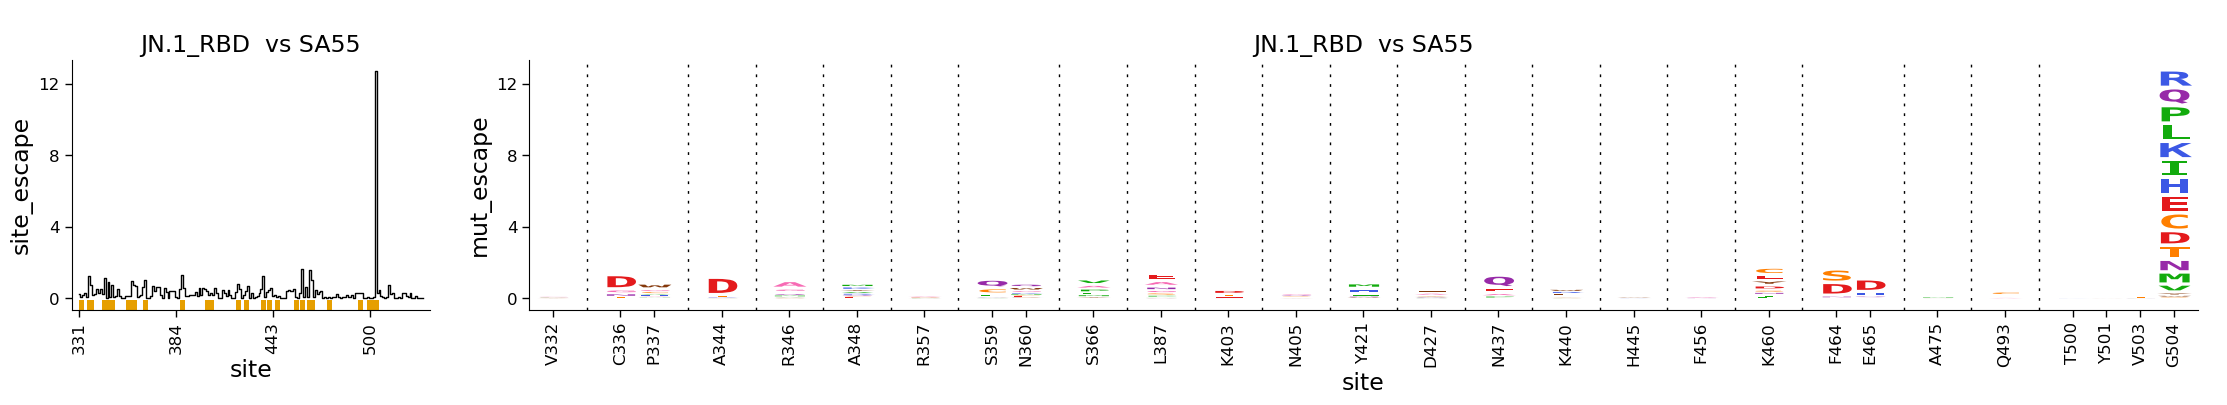

In [9]:
antibodies_of_interest = ["VYD222", "BD55-1205", "SA55"]
target_antigen = "JN.1_RBD"

for antibody in antibodies_of_interest:
    # grab only JN.1 for this antibody
    antibody_df = (
        df
        .query("antibody == @antibody and antigen == @target_antigen")
        .assign(
            site_escape=lambda x: x.groupby("site")["mut_escape"].transform("sum"),
            site_label=lambda x: x["wildtype"] + x["site"].astype(str),
        )
    )
    if antibody_df.empty:
        print(f"No data found for antibody={antibody} vs antigen={target_antigen}")
        continue

    # add sequential sites
    antibody_df = antibody_df.merge(
        antibody_df[["site"]]
            .drop_duplicates()
            .reset_index(drop=True)
            .reset_index(names="isite"),
        on="site",
        how="left"
    )

    # 1) existing show_site from long_df
    matching_sites = (
        long_df
        .query("antibody == @antibody and show_site")
        ["site"]
        .unique()
        .tolist()
    )
    antibody_df["show_site"] = antibody_df["site"].isin(matching_sites)

    # 2) OR in the 15 sites with highest summed mut_escape
    top15 = (
        antibody_df
        .groupby("site")["mut_escape"]
        .sum()
        .nlargest(15)
        .index
        .tolist()
    )
    antibody_df.loc[antibody_df["site"].isin(top15), "show_site"] = True

    # now plot just JN.1
    fig, axes = dmslogo.facet_plot(
        antibody_df,
        gridrow_col="antigen",
        x_col="isite",
        show_col="show_site",
        draw_line_kwargs={"height_col": "site_escape", "xtick_col": "site"},
        draw_logo_kwargs={
            "letter_col": "mutation",
            "letter_height_col": "mut_escape",
            "xtick_col": "site_label",
            "xlabel": "site",
        },
        share_ylim_across_rows=False,
        line_titlesuffix=f" vs {antibody}",
        logo_titlesuffix=f" vs {antibody}",
    )

    display(fig)
    plt.close(fig)

    # svg_path = os.path.join("results/escape_logos", f"{antibody}_{target_antigen}_line_logo_plot.svg")
    # fig.savefig(svg_path, format="svg", bbox_inches="tight")
    # print(f"Saved {svg_path}")

    plt.close(fig)

In [10]:
# I want to get top sites for Cao BD55-1205 data and then replot our DMS data with those sites

antibodies_of_interest = ["BD55-1205"]
target_antigen = "JN.1_RBD"

for antibody in antibodies_of_interest:
    # grab only JN.1 for this antibody
    antibody_df = (
        df
        .query("antibody == @antibody and antigen == @target_antigen")
        .assign(
            site_escape=lambda x: x.groupby("site")["mut_escape"].transform("sum"),
            site_label=lambda x: x["wildtype"] + x["site"].astype(str),
        )
    )
    if antibody_df.empty:
        print(f"No data found for antibody={antibody} vs antigen={target_antigen}")
        continue

    # add sequential sites
    antibody_df = antibody_df.merge(
        antibody_df[["site"]]
            .drop_duplicates()
            .reset_index(drop=True)
            .reset_index(names="isite"),
        on="site",
        how="left"
    )

    # 1) existing show_site from long_df
    matching_sites = (
        long_df
        .query("antibody == @antibody and show_site")
        ["site"]
        .unique()
        .tolist()
    )
    antibody_df["show_site"] = antibody_df["site"].isin(matching_sites)

    # 2) OR in the 15 sites with highest summed mut_escape
    top15 = (
        antibody_df
        .groupby("site")["mut_escape"]
        .sum()
        .nlargest(15)
        .index
        .tolist()
    )
    antibody_df.loc[antibody_df["site"].isin(top15), "show_site"] = True

In [11]:
df_ab = df_ab.drop(columns="show_site")

df_ab = df_ab.merge(
    antibody_df[["site", "show_site"]].drop_duplicates("site"),
    on="site",
    how="left"
)
df_ab["show_site"] = df_ab["show_site"].fillna(False).astype(bool)

/tmp/ipykernel_2894/3076634204.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ab["show_site"] = df_ab["show_site"].fillna(False).astype(bool)


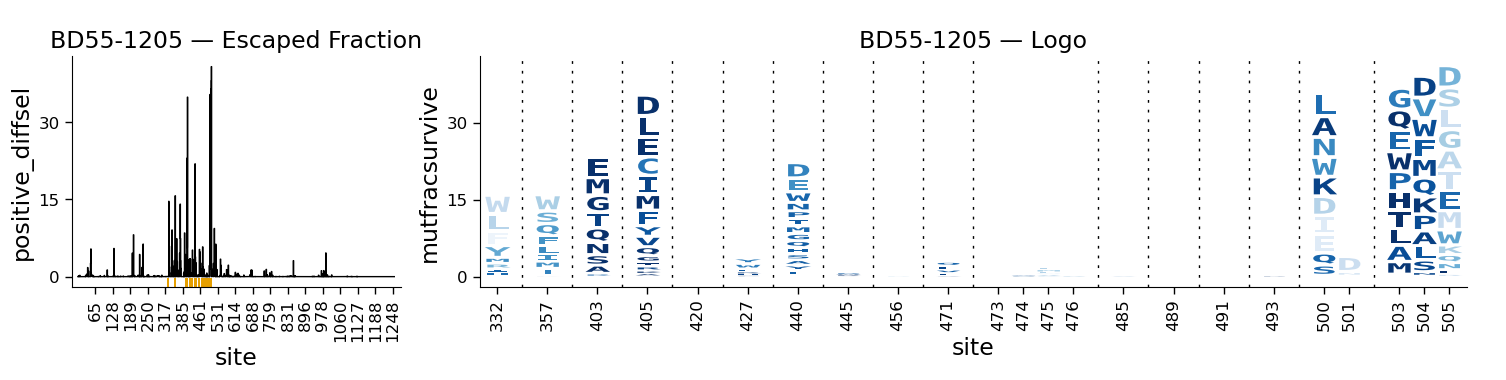

In [12]:
# … [everything up through building long_df and marking show_site stays exactly the same] …

# Now: only pick your antibody, but keep *all* its rows
ab = "BD55-1205"
# df_ab = long_df.query("antibody == @ab").copy()

# remap site → sequential integer
unique_sites = sorted(df_ab['site'].unique())
site_map = {s: i+1 for i,s in enumerate(unique_sites)}
df_ab['isite'] = df_ab['site'].map(site_map)

# set up figure
fig, axes = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1,3]})
fig.subplots_adjust(wspace=0.12)
fig.set_size_inches(18, 3)

# 1) Line plot: includes all rows but highlights show_site
dmslogo.draw_line(
    df_ab,
    x_col="isite",
    height_col="positive_diffsel",
    xtick_col="site",
    show_col="show_site",       # <— uses the flag to highlight
    ax=axes[0],
    title=f"{ab} — Escaped Fraction"
)

# 2) Logo plot: only for the flagged sites
dmslogo.draw_logo(
    df_ab[df_ab['show_site']],  # <— subset here
    x_col="isite",
    letter_col="mutation",
    letter_height_col="mutfracsurvive",
    clip_negative_heights=True,
    color_col="color",
    ax=axes[1],
    xtick_col="site",
    title=f"{ab} — Logo"
)

plt.show()
# save svg
# svg_path = os.path.join("results/escape_logos",f"{ab}_spike_DMS_line_logo_plot_match_Cao.svg")
# fig.savefig(svg_path, format="svg", bbox_inches="tight")
# print(f"Saved {svg_path}")
plt.close(fig)

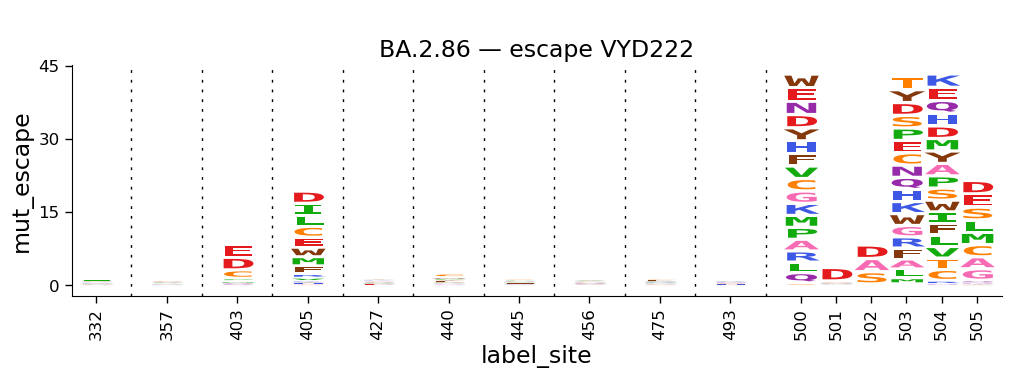

Saved ../results/escape_logos/BD55-1205_spike_DMS_line_logo_plot_match_Starr.svg


In [14]:
# Load BA.2.86 escape table
url = "https://media.githubusercontent.com/media/tstarrlab/SARS-CoV-2-RBD_Omicron_MAP_VYD222/refs/heads/main/results/escape_scores/escape_fracs_Omicron_BA286.csv"
df = pd.read_csv(url)

# Ensure label_site is string
df["label_site"] = df["label_site"].astype(str)

# Escape value
df["mut_escape"] = df["mut_escape_frac_single_mut"]

# Parse numeric site
df["site"] = df["label_site"].str[1:].astype(int)

sites_to_plot = sorted(df_ab.loc[df_ab["show_site"], "site"].unique())

df["label_site"] = df["label_site"].astype(int)

# # Subset BA.2.86 data to those sites only
df_top = df[df["label_site"].isin(all_top_sites)].copy()

# Collapse duplicates per (site, mutation)
df_plot = (
    df_top
    .groupby(["label_site", "mutation"], as_index=False)
    .agg(mut_escape=("mut_escape", "sum"))
)

# Plot
fig, ax = plt.subplots(figsize=(12, 3))

dmslogo.draw_logo(
    df_plot,
    x_col="label_site",                   # keep numeric
    letter_col="mutation",
    letter_height_col="mut_escape",
    clip_negative_heights=True,
    ax=ax,
    xtick_col="label_site",         # site labels like K417
    title="BA.2.86 — escape VYD222"
)

plt.show()
svg_path = os.path.join("../results/escape_logos",f"{ab}_spike_DMS_line_logo_plot_match_Starr.svg")
fig.savefig(svg_path, format="svg", bbox_inches="tight")
print(f"Saved {svg_path}")
fig.savefig(svg_path, format="svg", bbox_inches="tight")